This is a duplicate of notebook `1_data_preparation`, that aims to stratify the splits also in the `primary` and `hard` fields.

In [1]:
import json

dataset_path = "/home/peterr/macocu/task5_webgenres/data/original/dataset/dataset.json"

with open(dataset_path, "r") as f:
    dataset = json.load(f)


In [2]:
len(dataset)

1002

# Downsampling rare labels

Rarely occuring primary and secondary labels will be changed as per `Dictionaries_for_genre_mapping.py`:

In [3]:
# First step - categories with less than 5 examples are merged with other categories:
first = {"Script/Drama":"Other", "Lyrical":"Other","FAQ":"Other"}

# Second step - categories (marked by the arrow in the hierarchy figure) are merged with similar categories:
second = {"Recipe":"Instruction", "Research Article":"Information/Explanation", "Review":"Opinion/Argumentation", "Promotion of Services":"Promotion", "Promotion of a Product":"Promotion", "Invitation":"Promotion"}


In [4]:
for i, document in enumerate(dataset):
    primary = document["primary"]
    secondary = document["secondary"]

    if primary in first.keys():
        #print(f"Changing primary from {primary} to {first[primary]}")
        document["primary"] = first[primary]
        
    if secondary in first.keys():
        #print(f"Changing secondary from {secondary} to {first[secondary]}")
        document["secondary"] = first[secondary]

    if primary in second.keys():
        #print(f"Changing primary from {primary} to {second[primary]}")
        document["primary"] = second[primary]

    if secondary in second.keys():
        #print(f"Changing secondary from {secondary} to {second[secondary]}")
        document["secondary"] = second[secondary]

    dataset[i] = document


In total 262 changes were made.

Next: domains will be extracted from urls and saved in the dataset.

In [5]:
urls = [item["url"] for item in dataset]

starts = set([url[0:7] for url in urls])
print("URL starts: ", starts)

ends = set(url[-1] for url in urls)
print("URL ends: ", ends)


URL starts:  {'http://', 'https:/'}
URL ends:  {'u', '0', 'k', 'f', '1', 't', '9', '+', 'd', 'e', '5', 'h', 's', 'c', '/', '.', 'g', '4', '6', 'y', 'i', 'v', '=', 'M', 'a', 'p', 'x', 'n', 'l', 'L', '8', '&', 'j', '3', 'm', '7', 'o', '-', 'w', 'r', '2'}


As we see, all of the URLs start with either http or https. This will make parsing a bit easiers.

In [6]:
import parse

pattern = "{protocol}://{domain}/{rest}"
p = parse.compile(pattern)

for document in dataset:
    parse_result = p.parse(document["url"])
    try:
        document["domain"] = parse_result["domain"]
    except TypeError:
        print(document["url"])


http://multicsreen.uscom.si/
http://www.miroslav-vilhar.si/
http://www.miroslav-vilhar.si/
http://www.miroslav-vilhar.si/
http://pizza-grad.com/
https://postni-nabiralniki.si/
https://www.estet-interier.si/


As we see, this is a situation where we crawled URLs that do not have anything after the third slash. This will be solved by using a modified pattern, as can be seen below:

In [7]:
import parse

pattern = "{protocol}://{domain}/{rest}"
p = parse.compile(pattern)

modified_pattern = "{protocol}://{domain}/"
mp = parse.compile(modified_pattern)
for document in dataset:
    parse_result = p.parse(document["url"])
    try:
        document["domain"] = parse_result["domain"]
    except TypeError:
        parse_result = mp.parse(document["url"])
        document["domain"] = parse_result["domain"]


Let's inspect the first element to be sure that the documents have been modified correctly:

In [8]:
dataset[0]

{'id': '3949',
 'url': 'http://www.pomurje.si/aktualno/sport/zimska-liga-malega-nogometa/',
 'crawled': '2014',
 'primary': 'News/Reporting',
 'secondary': '',
 'tertiary': '',
 'hard': False,
 'paragraphs': [{'text': 'Šport', 'duplicate': False, 'keep': True},
  {'text': 'Zimska liga malega nogometa sobota, 12.02.2011',
   'duplicate': False,
   'keep': True},
  {'text': 'avtor: Tonček Gider', 'duplicate': False, 'keep': True},
  {'text': "V 7. krogu zimske lige v malem nogometu v Križevcih pri Ljutomeru je v prvi ligi vodilni 100 plus iz Križevec izgubil s tretjo ekipo na lestvici Rock'n roll iz Križevec z rezultatom 1:2, druga na lestvici Top Finedika iz Križevec je bila poražena z ekipo Bar Milene iz Ključarovec z rezultatom 7:8. V drugi križevski ligi je vodilni Cafe del Mar iz Vučje vasi premagal Montažo Vrbnjak iz Stare Nove vasi z rezultatom 3:2.",
   'duplicate': False,
   'keep': True},
  {'text': 'oglasno sporočilo', 'duplicate': False, 'keep': True},
  {'text': 'Ocena', 'du

# Transforming the dataset in tabular form

In [9]:
fields = dataset[0].keys()
fields

dict_keys(['id', 'url', 'crawled', 'primary', 'secondary', 'tertiary', 'hard', 'paragraphs', 'domain'])

In [10]:
tabular_dataset = dict()
for field in fields:
    tabular_dataset[field] = [item[field] for item in dataset]
tabular_dataset["stratum"] = [item["primary"] + str(item["hard"]) + item["crawled"] for item in dataset]

In [11]:
import pandas as pd

df = pd.DataFrame(data=tabular_dataset)
interim_dir = "/home/peterr/macocu/task5_webgenres/data/interim"
df.to_csv(interim_dir+"/tabular_1a.csv", index=False)
df.head()

,id,url,crawled,primary,secondary,tertiary,hard,paragraphs,domain,stratum
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,News/Reporting,,,False,"[{'text': 'Šport', 'duplicate': False, 'keep':...",www.pomurje.si,News/ReportingFalse2014
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,Information/Explanation,,,False,"[{'text': 'JEDILNIK', 'duplicate': False, 'kee...",www.ss-sezana.si,Information/ExplanationFalse2014
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,Promotion,Opinion/Argumentation,Information/Explanation,False,"[{'text': 'Projekt INNOVAge in zavod Oreli', '...",www.kamnik-starejsi.si,PromotionFalse2014
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,News/Reporting,,,False,"[{'text': 'V novembru, mesecu preprečevanja od...",www.radiocelje.si,News/ReportingFalse2014
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,Opinionated News,,,False,[{'text': 'Selena Gomez ponudila v poslušanje ...,www.mtv.si,Opinionated NewsFalse2014


In [12]:
df.crawled.unique()

array(['2014', '2021'], dtype=object)

In [13]:
nr_of_domains = df.domain.shape[0]
nr_of_unique_domains = len(df.domain.unique())
print("Unique domains: ", nr_of_unique_domains, " out of ", nr_of_domains)

Unique domains:  721  out of  1002


The output of the last cell is worrysome. We will have to assure that no two domains are simultaneously present in a single fold. 

In [14]:
counter = 0
distribution = list()
for domain in df.domain.unique():
    subset = df[df.domain == domain]
    if len(subset.crawled.unique()) == 1:
        pass
    else:
        counter += 1
    distribution.append(len(subset))
print(f"Found {counter} domains that were crawled in both years.")

Found 29 domains that were crawled in both years.


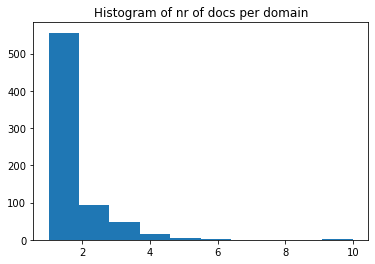

In [15]:
import matplotlib.pyplot as plt
plt.hist(distribution)
plt.title("Histogram of nr of docs per domain")
plt.show()

Ok, so only 29 domains were crawled in both years... Perhaps the stratification by year will be easy.

What to do next? Let's first see how the data distribution looks like when only unique domains are taken into account:


In [16]:
df["domain_unique"] = False
for domain in df.domain.unique():
    subset = df.loc[df.domain == domain,:]
    if len(subset) == 1:
        df.loc[df.domain == domain, "domain_unique"] = True

In [18]:
from sklearn.model_selection import train_test_split

train, devtest = train_test_split(df, test_size=0.2, stratify=df.stratum, random_state=42)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

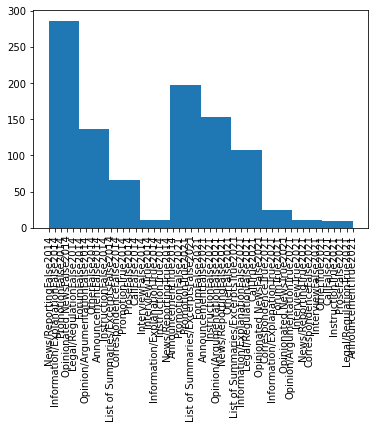

In [19]:
plt.hist(df.stratum)
plt.xticks(rotation=90)
plt.show()

Ok, we will obviously have to let go one of the parameters. Since hardness has behaved nicely in the previous attempts, it will be removed.